<a href="https://colab.research.google.com/github/phuvo05/AI-VIETNAM-ASSIGNMENT/blob/main/weather_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cài gdown
!pip install -q gdown

# Tải file từ link Drive
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown --id 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0 # ← thay bằng ID thật

# Giải nén
!unzip -q img_cls_weather_dataset.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=3f1b701a-f7f5-430f-9f86-4102c57079f4
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:08<00:00, 71.9MB/s]


## **1. Import libraries**

In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [22]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [23]:
root_dir = 'weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx : class_name \
        for label_idx, class_name in enumerate(sorted(os.listdir(root_dir)))
}



for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img_paths.append(img_path)
        labels.append(label_idx)

print(classes)
print(labels[2000])
print(img_paths[2000])

{0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}
2
weather-dataset/dataset/frost/3699.jpg


## **3. Train, val, test split**

In [24]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train,X_val, y_train, y_val = train_test_split(img_paths, labels, test_size= val_size, random_state= seed, shuffle = is_shuffle)
X_train,X_test, y_train, y_test = train_test_split(X_train, y_train, test_size= test_size, random_state= seed, shuffle = is_shuffle)


## **4. Create pytorch dataset and data preprocessing function**

In [25]:
class WeatherDataset(Dataset):
    def __init__(self, X,y,transform = None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]
def transform(img, img_size = (224,224)):
    img = img.resize(img_size)
    img = np.array(img)[...,:3]
    img = torch.tensor(img).permute(2,0,1).float()
    normalized_img = img/255.0

    return normalized_img


## **5. Create dataloader**

In [26]:
#Dataset for train test val

train_dataset = WeatherDataset(X_train, y_train, transform= transform)
val_dataset = WeatherDataset(X_val,y_val, transform=transform)
test_dataset = WeatherDataset(X_test, y_test, transform= transform)


In [27]:
# Dataloader

train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size= train_batch_size,
    shuffle= True
)

test_loader = DataLoader(
    test_dataset,
    batch_size= test_batch_size,
    shuffle= False
)

val_loader = DataLoader(
    val_dataset,
    batch_size= test_batch_size,
    shuffle= False
)

Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


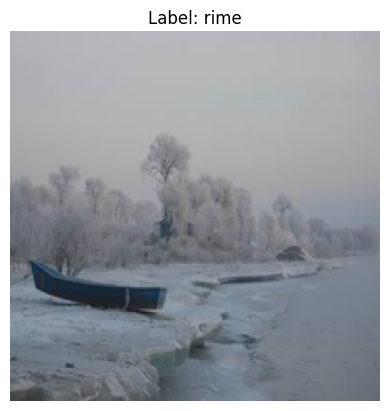

In [28]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [29]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

## **6. Create model**

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride= stride, padding= 1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride= 1, padding= 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size= 1,stride= stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [31]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_block_lst, n_classes):
        super(ResNet,self).__init__()
        self.conv1 = nn.Conv2d(3,64,kernel_size= 7, stride= 2, padding= 3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride= 2, padding= 1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_block_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128,n_block_lst[1],2)
        self.conv4 = self.create_layer(residual_block, 128,256,n_block_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256,512,n_block_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)
    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride= 1)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)
        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x= self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [32]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block= ResidualBlock,
    n_block_lst= [2,2,2,2],
    n_classes= n_classes
).to(device)

print(torch.cuda.is_available())

True


In [33]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


## **7. Training**

In [34]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [35]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [36]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [37]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)


EPOCH 1:	Train loss: 1.8807	Val loss: 2.3732
EPOCH 2:	Train loss: 1.3907	Val loss: 2.5000
EPOCH 3:	Train loss: 1.2435	Val loss: 2.7158
EPOCH 4:	Train loss: 1.1495	Val loss: 1.7004
EPOCH 5:	Train loss: 1.0944	Val loss: 1.5790
EPOCH 6:	Train loss: 1.0345	Val loss: 1.9053
EPOCH 7:	Train loss: 1.0001	Val loss: 1.0674
EPOCH 8:	Train loss: 0.9483	Val loss: 1.6505
EPOCH 9:	Train loss: 0.9527	Val loss: 1.5211
EPOCH 10:	Train loss: 0.8889	Val loss: 1.3919
EPOCH 11:	Train loss: 0.8512	Val loss: 1.1357
EPOCH 12:	Train loss: 0.8313	Val loss: 1.2887
EPOCH 13:	Train loss: 0.8313	Val loss: 1.1346
EPOCH 14:	Train loss: 0.7670	Val loss: 1.2554
EPOCH 15:	Train loss: 0.7272	Val loss: 0.8710
EPOCH 16:	Train loss: 0.7746	Val loss: 1.2980
EPOCH 17:	Train loss: 0.7534	Val loss: 1.0608
EPOCH 18:	Train loss: 0.6743	Val loss: 1.6355
EPOCH 19:	Train loss: 0.6576	Val loss: 2.1788
EPOCH 20:	Train loss: 0.6398	Val loss: 1.7278
EPOCH 21:	Train loss: 0.5898	Val loss: 1.5273
EPOCH 22:	Train loss: 0.6196	Val loss: 1.82

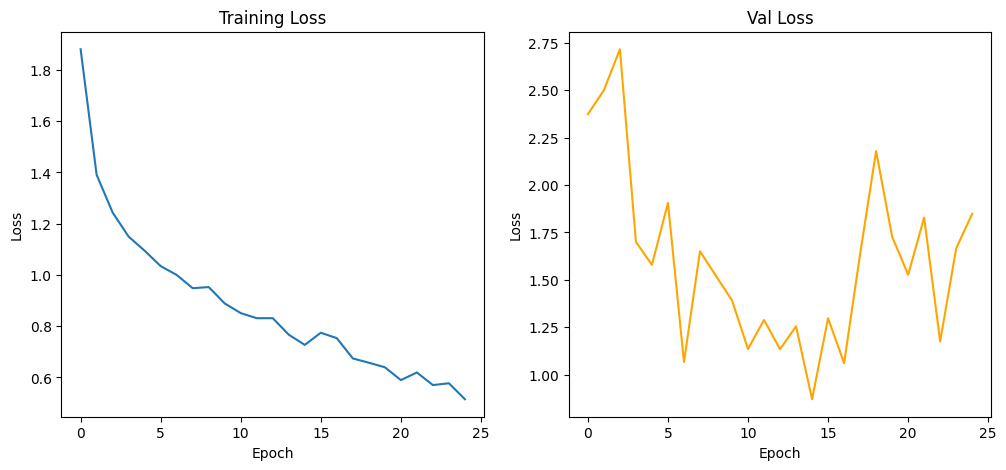

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **8. Evaluation**

In [38]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('evaluation on val/test dataset')
print('Val accuracy: ',val_acc)
print('Test accuracy: ', test_acc)

evaluation on val/test dataset
Val accuracy:  0.48871085214857973
Test accuracy:  0.45269286754002913
